In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
#import seaborn as sns
#import datetime
from datetime import datetime, timedelta
import re
import scipy.io
from netCDF4 import Dataset
import sys
%matplotlib inline 
import pickle
import time
import imp
import netCDF4
import copy

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
/sw1/wangs/anaconda3.6_new/bin/python


In [4]:
from module_wk_diagram import dispersion_relation, calc_wk_diagram

In [5]:
# -------------------------------------------------------------------------------------------------
def load_noaa_olr_and_highpass_filter(ofile='interp_OLR.day.mean.nc', bandpass=[1/96,1/2]):

    fout = netCDF4.Dataset(ofile,'r',mmap=False)
    lats = fout.variables['lat'][:].squeeze()
    lons = fout.variables['lon'][:].squeeze()
    time = fout.variables['time'][:].squeeze()
    olr = fout.variables['olr'][:].squeeze()
    fout.close()


    ilat_sel = (lats>=-30) & (lats<=30)
    lats = lats[ilat_sel]
    olr = olr[:,ilat_sel,:]

    nt, nlat, nlon = olr.shape
    otime = [datetime(1974,6,1)+ timedelta(tt/1.0) for tt in time]
    otime = [datetime(1800,1,1)+ timedelta(tt/24.0) for tt in time]
    
    print(otime[0], otime[-1])
    otime_ord = np.array([tt.toordinal() for tt in otime])
    tsel = np.where( (otime_ord >= datetime(1979,1,1).toordinal()) & \
                     (otime_ord <= datetime(2020, 6,30).toordinal()))[0]
    olr = olr[tsel,:,:]
    otime_ord = otime_ord[tsel]
    olr.shape, otime_ord.shape

    otime = [otime[ii] for ii in tsel]
  
    olr_obs_filt  = np.zeros(olr.shape)
    fft_freq = np.fft.fftfreq(olr.shape[0])
    for ii in np.arange(nlon):
        for jj in np.arange(nlat):
 
            otmp = olr[:,jj,ii]            
            fft_coef = np.fft.fft(otmp)
            ifreq_sel = np.where(np.abs(fft_freq)<=bandpass[0])[0]
            fft_coef[ifreq_sel] = 0.0 
            otmp = np.real(np.fft.ifft(fft_coef))
            olr_obs_filt[:,jj,ii] = otmp

    return olr_obs_filt, olr, lons, lats, otime

# download the OLR data here with wget or using built-in opendap with xarray or netCDF4:
ftp://ftp.cdc.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc

In [6]:
infile='/dxsw01/wangs/noaa_daily_realtime/olr.day.mean.nc'

In [7]:
olr_obs_filt_96, _, olons, olats, dtime = load_noaa_olr_and_highpass_filter(ofile=infile, bandpass=[1/96.0, ])

1974-06-01 00:00:00 2018-12-31 00:00:00


In [8]:
olats[6]

15.0

In [9]:
#Input: OLR between 15N - 15S
olr_15NS = olr_obs_filt_96[:,6:-6,:]

144 13 14610
13 7
(144, 96)


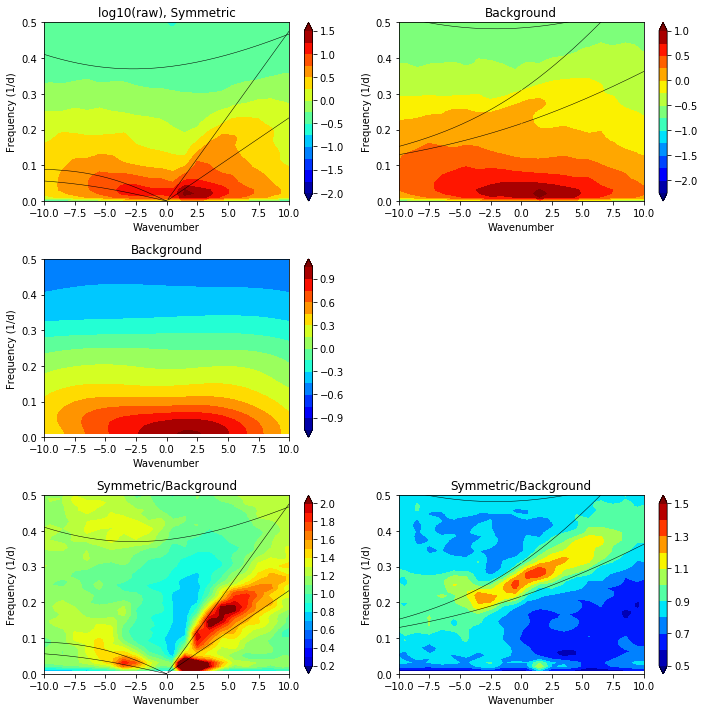

In [10]:
x_wn, y_freq, pwrdiv_sym, pwrdiv_anti, pwrplot_sym, pwrplot_anti, pwrsmth_olr_obs = \
           calc_wk_diagram(np.transpose(olr_15NS,[2,1,0]),   olons, title='OLR', plot=True );

# Beautify the colormap to match it with NCL: https://www.ncl.ucar.edu/Applications/space_time.shtml

In [11]:
import nlcmap
from colors import gen_cmap
cmap_amwg_blueyellowred = gen_cmap('amwg_blueyellowred')

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [13]:
def plot_waves(lon, ax, opt='sym'):    
    nx = len(lon)    
    rlat = 0.0
    hres=(lon[1]-lon[0])*(2*np.pi*6400)/360*np.cos(rlat*np.pi/180); # [km] zonal gridpoint spacing 27.75
    
    x11 = np.arange(-(nx-1)/2, (nx-1)/2+0.1, 0.1)/(nx*hres) # [1/km] zonal wavenumber
    x112 = np.arange(-(nx-1)/2, (nx-1)/2+0.1, 0.1); # [1/km] zonal wavenumber
    
    if opt == 'sym':
        for w in [4,5,6]: #asym 1:3, sym 4:6
            ax.plot(x112,dispersion_relation(x11,rlat,12,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,dispersion_relation(x11,rlat,90,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,-dispersion_relation(x11,rlat,12,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,-dispersion_relation(x11,rlat,90,w)*24, 'k', linewidth=0.5)
        #plt.plot(x112,dispersion_relation(x11,rlat,4,5)*24)
    elif opt == 'anti':
         for w in [1,2,3]: #asym 1:3, sym 4:6
            ax.plot(x112,dispersion_relation(x11,rlat,12,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,dispersion_relation(x11,rlat,90,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,-dispersion_relation(x11,rlat,12,w)*24, 'k', linewidth=0.5)
            ax.plot(x112,-dispersion_relation(x11,rlat,90,w)*24, 'k', linewidth=0.5)        
        
    klimit = 15
    wlimit = 0.5
    ax.axis([-klimit, klimit, 0, wlimit])   

#plot_waves(olons, plt.gca())    

In [14]:
cn_int = np.hstack((np.arange(0.2,1.3,0.1), [1.4, 1.7, 2, 2.4, 2.8, 3]))
cmap_test = ListedColormap(cmap_amwg_blueyellowred)
cmap_nonlin = nlcmap.nlcmap(cmap_test, cn_int)

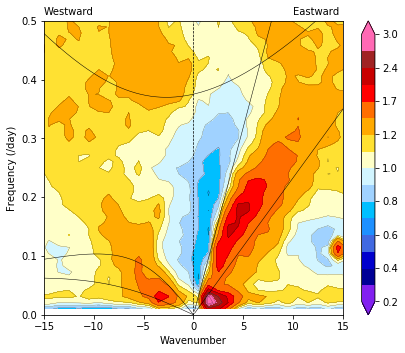

In [15]:
plt.figure(figsize=(6,5))

plt.contourf(x_wn, y_freq, pwrdiv_sym.T, levels=cn_int,  cmap=cmap_nonlin,  extend='both' )
plt.xlim([-15, 15])
plt.ylim([0, 0.5])
plt.colorbar()
plt.contour(x_wn, y_freq, pwrdiv_sym.T, levels=cn_int,  colors='k', linewidths=0.2 )
x0 = np.arange(0,0.51,0.05)
plt.plot(x0*0, x0, '--', color='k', linewidth=0.7)
plt.xlabel('Wavenumber')
plt.ylabel('Frequency (/day)')
plot_waves(olons, plt.gca())
plt.text(-15, 0.51, 'Westward')
plt.text(10, 0.51, 'Eastward')
 
plt.tight_layout()
#plt.savefig('wk_OLR_15NS.png', dpi=300)

In [16]:
cn_int2 =  np.arange(0.2,1.9,0.1)
cmap_test = ListedColormap(cmap_amwg_blueyellowred)
cmap_nonlin2 = nlcmap.nlcmap(cmap_test, cn_int2)

In [17]:
cmap_amwg_blueyellowred.shape, cn_int.shape, cn_int2.shape

((16, 3), (17,), (17,))

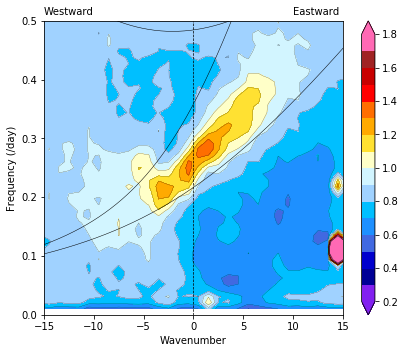

In [18]:
plt.figure(figsize=(6,5))

plt.contourf(x_wn, y_freq, pwrdiv_anti.T, levels=cn_int2,  cmap=cmap_nonlin2, extend='both'  )
plt.xlim([-15, 15])
plt.ylim([0, 0.5])
plt.colorbar()
plt.contour(x_wn, y_freq, pwrdiv_anti.T, levels=cn_int2,  colors='k', linewidths=0.2 )
x0 = np.arange(0,0.51,0.05)
plt.plot(x0*0, x0, '--', color='k', linewidth=0.7)
plt.xlabel('Wavenumber')
plt.ylabel('Frequency (/day)')
plot_waves(olons, plt.gca(), opt='anti')
plt.text(-15, 0.51, 'Westward')
plt.text(10, 0.51, 'Eastward')
 
plt.tight_layout()
#plt.savefig('wk_OLR_15NS.png', dpi=300)